#Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Load Data

In [10]:
# Load the dataset
data = pd.read_csv('/content/ecommerce_customer_data_custom_ratios.csv')

In [11]:
data.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


In [12]:
data.shape

(250000, 13)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202404 non-null  float64
 9   Customer Name          250000 non-null  object 
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  object 
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.8+ MB


# Data Visualization


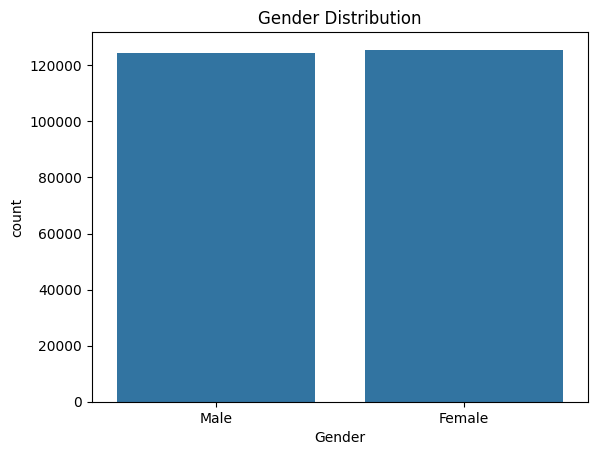

In [14]:
# Countplot of categorical variables
sns.countplot(x='Gender', data=data)
#sns.countplot(data['Gender'])
plt.title('Gender Distribution')
plt.show()

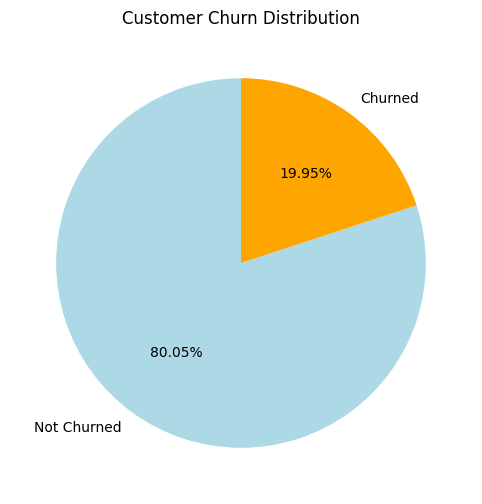

In [15]:
churn_counts = data["Churn"].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 6))
churn_counts.plot.pie(
    autopct='%1.2f%%',  # Show percentages
    startangle=90,      # Start at 90 degrees
    labels=['Not Churned', 'Churned'],  # Add labels
    colors=['lightblue', 'orange'],    # Colors for the pie
)

plt.title("Customer Churn Distribution")
plt.ylabel("")  # Hide the y-axis label
plt.show()

<Axes: >

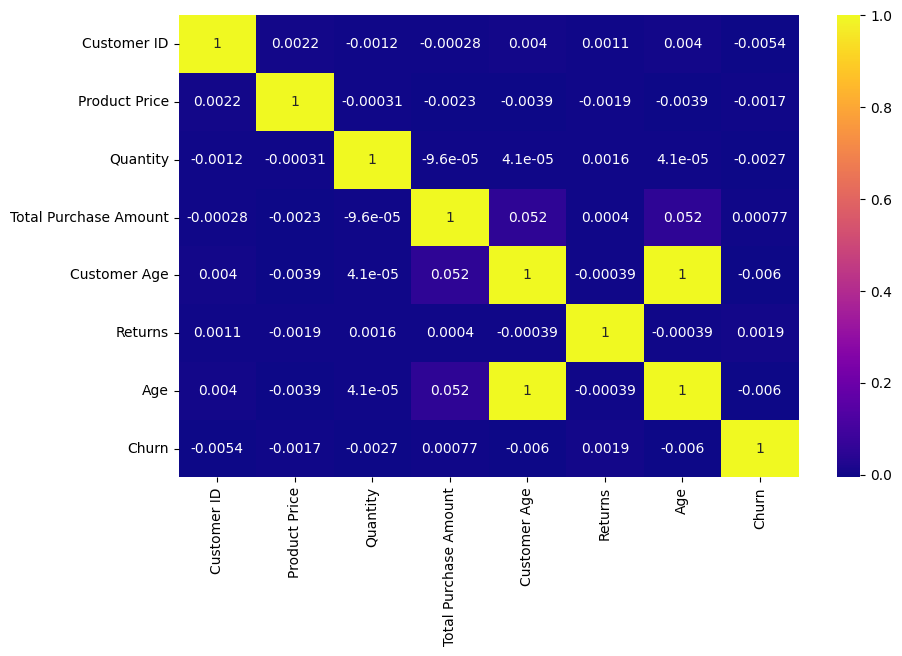

In [16]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap='plasma')

RFM

In [17]:
# 'Purchase Date' is datetime
data['Purchase Date'] = pd.to_datetime(data['Purchase Date'])

# Find the most recent purchase date in the dataset
max_date = data['Purchase Date'].max()

# Calculate Recency for each Customer ID
data['Recency'] = data.groupby('Customer ID')['Purchase Date'].transform(lambda x: (max_date - x.max()).days)

In [18]:
# Count the number of transactions for each Customer ID
data['Frequency'] = data.groupby('Customer ID')['Purchase Date'].transform('count')

In [19]:
# Sum the Total Purchase Amount for each Customer ID
data['Monetary'] = data.groupby('Customer ID')['Total Purchase Amount'].transform('sum')

In [20]:
data[['Recency','Frequency','Monetary']].head()

,Recency,Frequency,Monetary
0,479,4,10184
1,479,4,10184
2,479,4,10184
3,479,4,10184
4,153,5,12223


#Data processing

In [21]:
# Drop columns that don't add value for predictions
data = data.drop(columns=['Customer ID', 'Customer Name', 'Purchase Date', 'Age'])

In [22]:
# Check for missing values
data.isnull().sum()

,0
Product Category,0
Product Price,0
Quantity,0
Total Purchase Amount,0
Payment Method,0
Customer Age,0
Returns,47596
Gender,0
Churn,0
Recency,0


In [23]:
# Fill missing values for numerical columns with the median
missing_values_cols = ['Returns']
for col in missing_values_cols:
    data[col].fillna(data[col].median(), inplace=True)

In [24]:
# Verify there are no missing values left
data.isnull().sum()

,0
Product Category,0
Product Price,0
Quantity,0
Total Purchase Amount,0
Payment Method,0
Customer Age,0
Returns,0
Gender,0
Churn,0
Recency,0


In [25]:
# Detect outliers using IQR
def handle_outliers(df, col):
    Q1 = df[col].quantile(0.25)  # First quartile
    Q3 = df[col].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound))

    # Count and print the number of outliers
    num_outliers = outliers.sum()
    print(f"Number of outliers in '{col}': {num_outliers}")


# Apply the function to numerical columns
numerical_cols = ['Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age', 'Returns']
for col in numerical_cols:
    handle_outliers(data, col)

Number of outliers in 'Product Price': 0
Number of outliers in 'Quantity': 0
Number of outliers in 'Total Purchase Amount': 0
Number of outliers in 'Customer Age': 0
Number of outliers in 'Returns': 0


# Feature Engineering

 Encode Categorical Variables

In [26]:
# Encode categorical columns
le = LabelEncoder()
for column in ['Product Category', 'Payment Method', 'Gender']:
    data[column] = le.fit_transform(data[column])

Scale Numerical Features

In [27]:
scaler = StandardScaler()
numerical_features = ['Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age', 'Returns']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

Define Target and Features

In [28]:
X = data.drop(columns=['Churn'])  # Features
y = data['Churn']  # Target

Splitting the Data

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Data balancing using SMOTE

In [30]:
# Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# K-Means Clustering


In [31]:
# Apply K-Means clustering on the balanced dataset
kmeans = KMeans(n_clusters=3, random_state=42)

In [32]:
# Calculate WCSS for different values of k (number of clusters)
wcss = []
for k in range(1, 11):  # Try cluster counts from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_balanced)
    wcss.append(kmeans.inertia_)

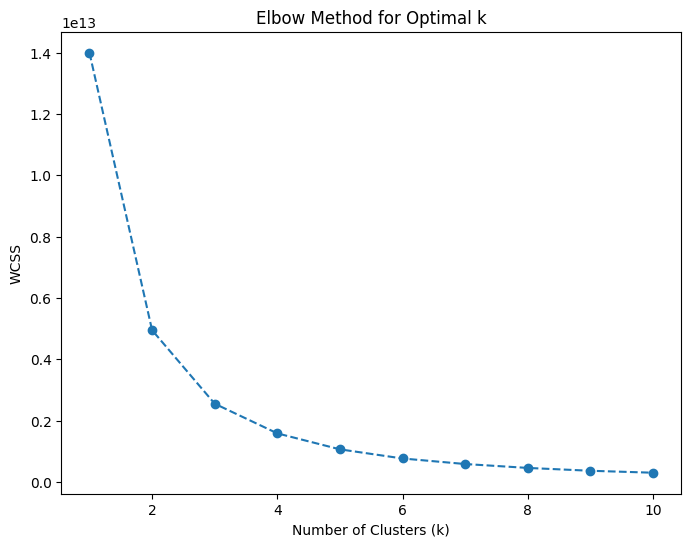

Elbow Curve plotted successfully. Use the 'elbow' point to determine the optimal number of clusters.


In [33]:
# Plot the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Print a message indicating the Elbow Curve has been plotted
print("Elbow Curve plotted successfully. Use the 'elbow' point to determine the optimal number of clusters.")


In [34]:
# Use PCA for dimensionality reduction to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_train_balanced)  # Apply PCA to the balanced training dataset

In [35]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_train_balanced)

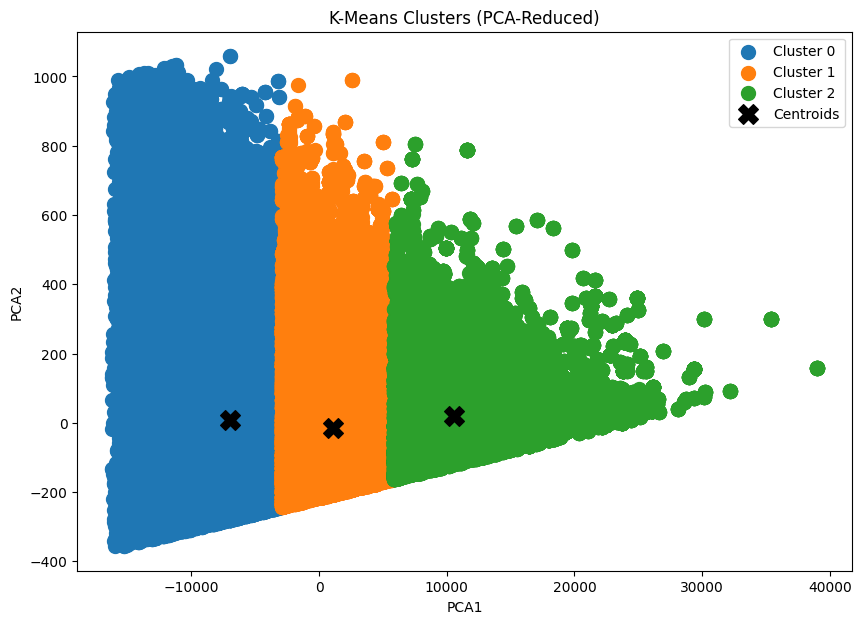

In [36]:
# Visualize Clusters
# Create a DataFrame for the reduced data
clustered_data = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2']) # Store PCA-reduced features
clustered_data['Cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    cluster_points = clustered_data[clustered_data['Cluster'] == cluster] # Filter data for the current cluster
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'], label=f'Cluster {cluster}', s=100)

# Add centroids to the plot
centroids = kmeans.cluster_centers_
centroids_reduced = pca.transform(centroids) # Reduce centroids to 2D using PCA
plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], c='black', marker='X', s=200, label='Centroids')

plt.title('K-Means Clusters (PCA-Reduced)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

#Machine Learning Models

Logistic Regression

In [37]:
# Hyperparameter tuning for Logistic Regression
param_grid_lr = {'C': [0.1, 1, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, scoring='accuracy', cv=5)
grid_search_lr.fit(X_train_balanced, y_train_balanced )
print("Best Parameters (Logistic Regression):", grid_search_lr.best_params_)

Best Parameters (Logistic Regression): {'C': 0.1}


In [38]:
# Train the best model
lr = LogisticRegression(C=grid_search_lr.best_params_['C'])
lr.fit(X_train_balanced, y_train_balanced )

LogisticRegression(C=0.1)

In [39]:
y_pred_lr = lr.predict(X_test)

In [40]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

Accuracy: 0.5402266666666666


In [41]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Confusion Matrix:
 [[34186 25852]
 [ 8631  6331]]


In [42]:
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.57      0.66     60038
           1       0.20      0.42      0.27     14962

    accuracy                           0.54     75000
   macro avg       0.50      0.50      0.47     75000
weighted avg       0.68      0.54      0.59     75000



Random Forest

In [43]:
# Shrinking the parameter grid further
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

In [44]:
# Randomized search with fewer iterations
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=5,  # Fewer iterations
    scoring='accuracy',
    cv=2,  # Using 2-fold instead of 3-fold
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all cores for parallel processing
)

# Fit the model
random_search_rf.fit(X_train_balanced, y_train_balanced)
# Print the best parameters and accuracy
print(f"Best Parameters: {random_search_rf.best_params_}")

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}


In [45]:
# Train model
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

In [46]:
# Evaluation
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_rf)}")

Random Forest Test Accuracy: 0.7921466666666667


In [47]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Confusion Matrix:
 [[59039   999]
 [14590   372]]


In [48]:
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88     60038
           1       0.27      0.02      0.05     14962

    accuracy                           0.79     75000
   macro avg       0.54      0.50      0.46     75000
weighted avg       0.70      0.79      0.72     75000



Gradient Boosting

In [49]:
# Define the parameter grid
param_dist = {
    'n_estimators': [50, 100],  # Number of trees
    'learning_rate': uniform(0.01, 0.1),  # Range of learning rates
    'max_depth': [3, 5],  # Depth of the trees
    'min_samples_split': [2, 5],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2],  # Minimum samples in a leaf node
    'subsample': [0.8, 1.0],  # Fraction of samples used for training each tree
    'max_features': ['sqrt', 'log2']  # Number of features to consider for splits
}


# RandomizedSearchCV with iterations and cross-validation folds
random_search_gb = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42, warm_start=True, n_iter_no_change=5, tol=0.01),
    param_distributions=param_dist,
    n_iter=10,  # Reduce number of iterations to 10
    scoring='accuracy',
    cv=3,  # Use 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all cores for parallelism
)


# Fit the model
random_search_gb.fit(X_train_balanced, y_train_balanced)
# Print the best parameters and accuracy
print(f"Best Parameters: {random_search_gb.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'learning_rate': 0.07011150117432088, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [50]:
# Train model
best_gb_model = random_search_gb.best_estimator_
y_pred_gb = best_gb_model.predict(X_test)

In [51]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_gb))

Accuracy: 0.7691466666666666


In [52]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))

Confusion Matrix:
 [[56918  3120]
 [14194   768]]


In [53]:
print("Classification Report:\n", classification_report(y_test, y_pred_gb))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87     60038
           1       0.20      0.05      0.08     14962

    accuracy                           0.77     75000
   macro avg       0.50      0.50      0.47     75000
weighted avg       0.68      0.77      0.71     75000



Decision Tree

In [54]:
# Define the parameter grid
param_grid_dt = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, scoring='accuracy', cv=5)

In [55]:
# Fit to training data
grid_search_dt.fit(X_train_balanced, y_train_balanced)
print("Best Parameters (Decision Tree):", grid_search_dt.best_params_)

Best Parameters (Decision Tree): {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [56]:
# Train the Decision Tree with the best parameters
dt = DecisionTreeClassifier(**grid_search_dt.best_params_, random_state=42)
dt.fit(X_train_balanced, y_train_balanced)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=2, random_state=42)

In [57]:
# Make predictions on the test set
y_pred_dt = dt.predict(X_test)

In [58]:
# Test accuracy
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))

Decision Tree Accuracy: 0.7878666666666667


In [59]:
# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Confusion Matrix:
 [[58716  1322]
 [14588   374]]


In [60]:
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88     60038
           1       0.22      0.02      0.04     14962

    accuracy                           0.79     75000
   macro avg       0.51      0.50      0.46     75000
weighted avg       0.69      0.79      0.71     75000



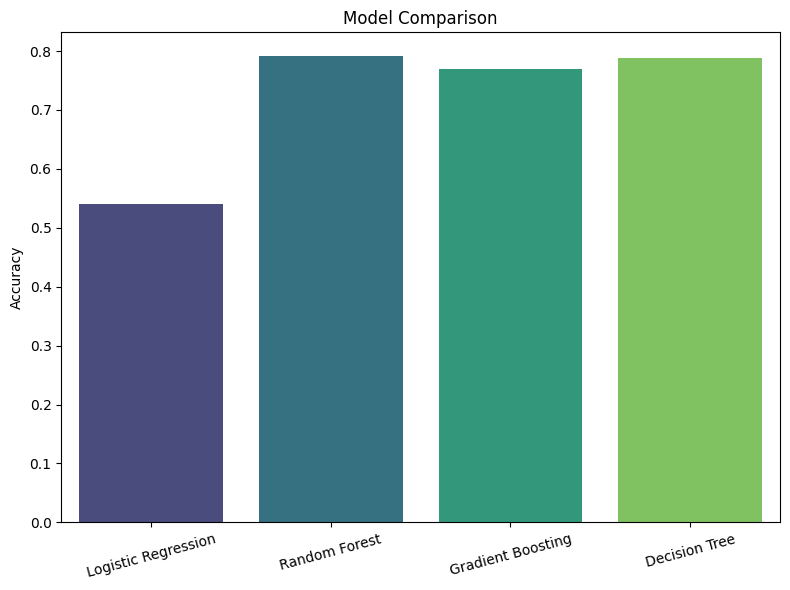

In [61]:
# Collect results
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Decision Tree'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_gb),
        accuracy_score(y_test, y_pred_dt)
    ]
})

# Plot the results
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=results, palette='viridis')
plt.title("Model Comparison")
plt.ylabel("Accuracy")
plt.xlabel("")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()